# Imports

In [1]:
import numpy as np
from pathlib import Path
from importlib import reload

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# figure aesthetics
plt.style.use(["../utils/dark.mplstyle","../utils/notebook.mplstyle"])  # for dark themes
# plt.style.use(["../utils/notebook.mplstyle"])  # for light theme

cdata, cslow, cfast = 'C0', 'C1', 'C2'

In [3]:
# custom libraries
import sys, os

sys.path.append(os.path.abspath('../../spaths'))
import spaths

sys.path.append(os.path.abspath('..'))
import sf_nets.utils.dmaps as dmaps
from sf_nets.utils.mpl_utils import coord_grid

# System

In [4]:
eps = 1e-3

# observed process coefficients
def drift_obs(t, z, dz):
    x, y = z
    dz[0] = np.sin(y) + np.cos(y)*(np.sin(x-np.sin(y))-y)/eps - np.sin(y)/(2*eps)
    dz[1] = (np.sin(x-np.sin(y))-y) / eps

def dispersion_obs(t, z, dz):
    x, y = z
    dz[0,0] = np.sqrt(1 + .5*np.sin(y))
    dz[0,1] = np.cos(y)/np.sqrt(eps)
    dz[1,1] = 1.0 / np.sqrt(eps)

sde = spaths.ItoSDE(drift_obs, dispersion_obs, noise_mixing_dim=2)

In [5]:
def slow_map(x):
        x1, x2 = x
        return np.array([x1 - np.sin(x2)])

In [6]:
# seed setting and solver
seed = 3579
rng = np.random.default_rng(seed)
rng.integers(10**3);  # warm up of RNG

# stochastic solver
em = spaths.EulerMaruyama(rng)

In [7]:
# simulation params
dt = eps / 4
x0 = 1.0, 1.0
tspan = (0.0, 200.0)

# Path

In [8]:
ens0 = np.array([x0]) #spaths.make_ens(x0, y0)
sol_obs = em.solve(sde, ens0, tspan, dt)

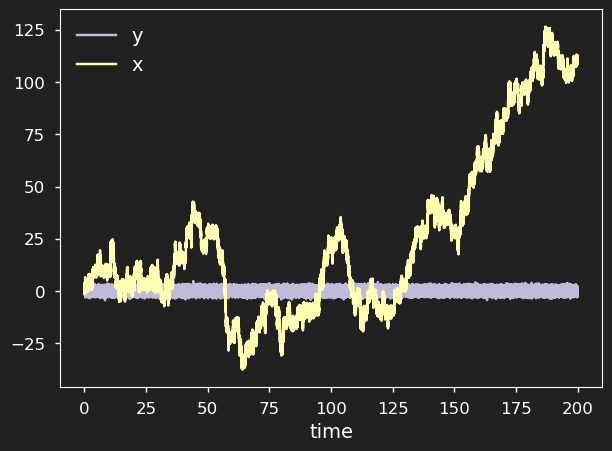

In [9]:
path = sol_obs.p[0]
plt.plot(sol_obs.t, path.T[1], label='y', c=cfast)
plt.plot(sol_obs.t, path.T[0], label='x', c=cslow)
plt.xlabel("time")
plt.legend()
plt.show()

In [10]:
x, y = sol_obs.p[0].T
x = np.mod(x, 2*np.pi)
path = np.array([x, y]).T

# Data from the observed system

In [11]:
data = path[1::200].astype(np.float32)
print(f"{data.shape = }")
print(f"{data.dtype = }")

data.shape = (4001, 2)
data.dtype = dtype('float32')


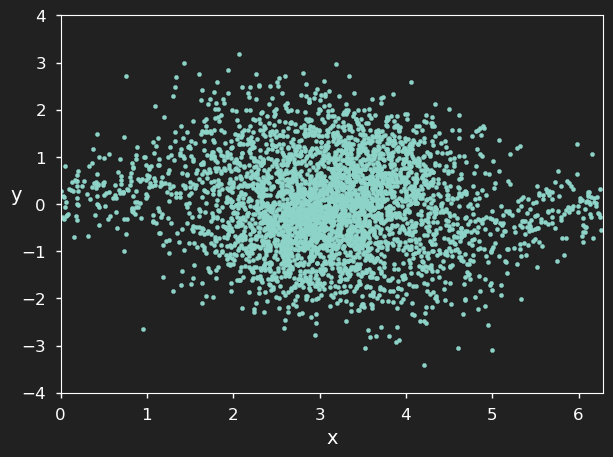

In [12]:
plt.scatter(*data.T, c=cdata);
plt.xlabel("x")
plt.ylabel("y", rotation=0)
plt.xlim([0,2*np.pi])
plt.ylim([-4,4]);

## Time-scale separation

In [13]:
# local noise covaraiances of sde at the data points
ln_covs = dmaps.lnc_ito(data, sde)

In [14]:
e_vals, e_vecs = zip(*[np.linalg.eigh(cov) for cov in ln_covs])  # zip(*...) is equiv to transposing :)
e_vals, e_vecs = np.array(e_vals), np.array(e_vecs)

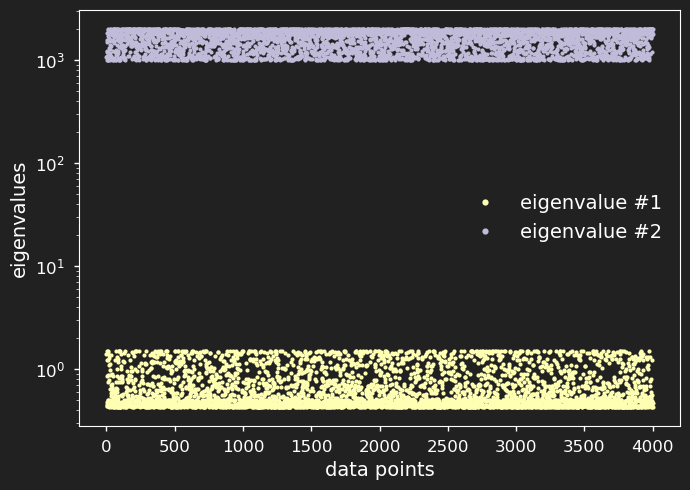

In [15]:
fig, ax = plt.subplots()
for n, (e_val, col) in enumerate(zip(e_vals.T, [cslow, cfast])):
    ax.plot(e_val, 'o', label=f"eigenvalue #{n+1}", c=col)
ax.legend()
ax.set_yscale('log')

ax.set_xlabel('data points')
ax.set_ylabel('eigenvalues')

fig.tight_layout()
plt.show(fig)
plt.close(fig)

## Fast fibers

### Short trajectories along fibers

In [16]:
def plot_fibs(data, sde, tspan, dt, c=None):
    fib_paths = em.solve(sde, data, tspan, dt).p
    for fib_path in fib_paths:
        plt.scatter(*fib_path.T, s=7, c=c);

In [17]:
def to_darray(*meshgrids):
    return np.stack(meshgrids).reshape(len(meshgrids), -1).T

def to_grid(darray, grid_size):
    if darray.ndim == 1:
        return darray.reshape(grid_size, -1)
    else:
        return darray.reshape(darray.shape[1], grid_size, -1)

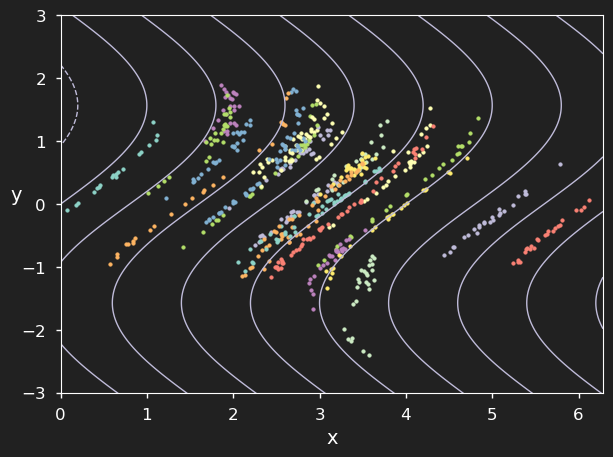

In [18]:
plot_fibs(data[::150], sde, (0, 1.5*eps), dt/4)
plt.xlabel("x")
plt.ylabel("y", rotation=0)

plt.xlim([0,2*np.pi])
plt.ylim([-3,3])

mesh_size = 400
x = np.linspace(+0.0, 2*np.pi, mesh_size)
y = np.linspace(-3.1, 3.1, mesh_size)
X, Y = np.meshgrid(x, y)

mesh_data = to_darray(X, Y)
v = slow_map(mesh_data.T).T
V = np.squeeze(to_grid(v, mesh_size))

ctrs = plt.contour(X, Y, V, levels=10, colors=cfast, linewidths=1)
# plt.plot(np.sin(y)+3, y)

plt.show()

In [24]:
def plot_fibs2(data, sde, nreps, tspan, dt, c=None):
    ens0 = np.repeat(data, nreps, axis=0)
    nsteps = int(tspan[1]/dt)
    fib_paths = em.burst(sde, ens0, (0, nsteps), dt).reshape(len(data), nreps, 2)
    for fib_path in fib_paths:
        plt.scatter(*fib_path.T, s=7, c=c);

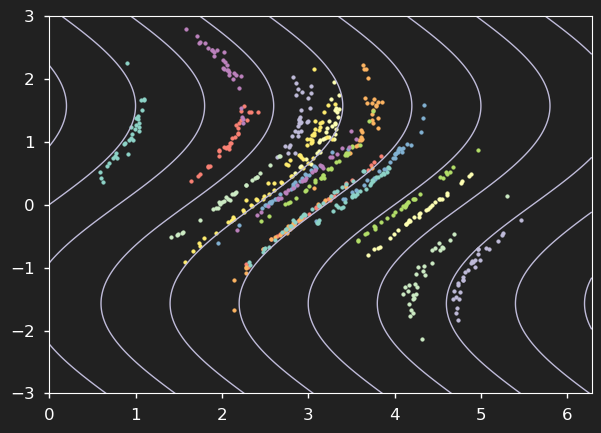

In [44]:
plot_fibs2(data[::200], sde, 30, (0, .2*eps), dt/10)

mesh_size = 400
x = np.linspace(+0.0, 2*np.pi, mesh_size)
y = np.linspace(-3.1, 3.1, mesh_size)
X, Y = np.meshgrid(x, y)

mesh_data = to_darray(X, Y)
v = slow_map(mesh_data.T).T
V = np.squeeze(to_grid(v, mesh_size))

ctrs = plt.contour(X, Y, V, levels=10, colors=cfast, linewidths=1, linestyles='solid')
# plt.plot(np.sin(y)+3, y)

plt.xlim([0,2*np.pi])
plt.ylim([-3,3])

plt.show()

### Transformation of slow map

In [38]:
def quad_slow_map(x):
    return (slow_map(x)-3.0)**2

(400, 400)


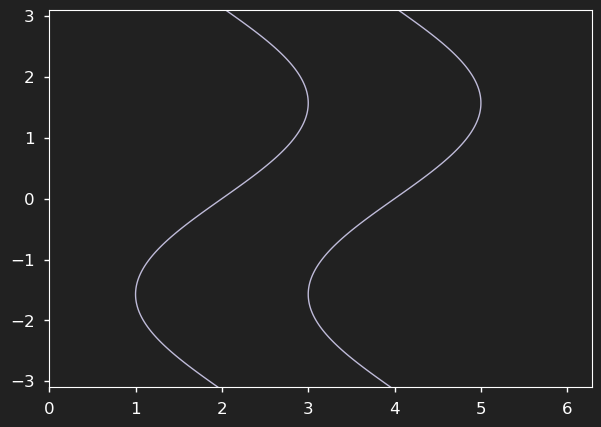

In [54]:
qs = quad_slow_map(mesh_data.T).T
QS = np.squeeze(to_grid(qs, mesh_size))
print(QS.shape)

ctrs = plt.contour(X, Y, QS, levels=[1], colors=cfast, linewidths=1)

In [55]:
def max_slow_map(x):
    sm = slow_map(x)
    return np.maximum(3.0*np.ones_like(sm), sm)

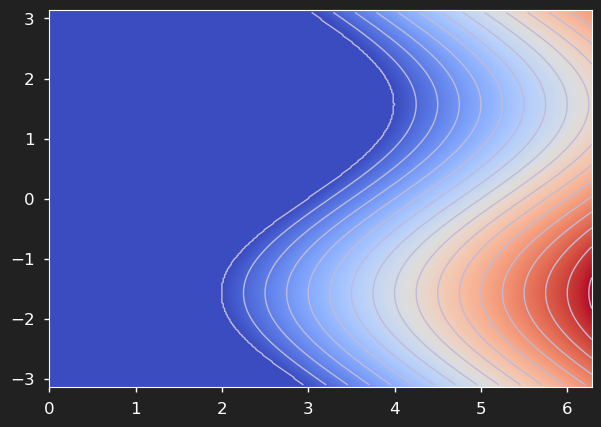

In [66]:
ms = max_slow_map(mesh_data.T).T
MS = np.squeeze(to_grid(ms, mesh_size))

plt.imshow(MS, origin='lower', extent=(0, 2*np.pi, -np.pi, np.pi), aspect='auto')
ctrs = plt.contour(X, Y, MS, levels=20, colors=cfast, linewidths=1)


### Local noise directions along a fiber

In [19]:
ctr = ctrs.allsegs[6][0]
ctr.shape

(649, 2)

In [20]:
ctr_dat=ctr[::70]

In [21]:
# local noise covaraiances of sde at the data points
ctr_lncs = dmaps.lnc_ito(ctr_dat, sde)

In [22]:
ctr_evals, ctr_evecs = zip(*[np.linalg.eigh(cov) for cov in ctr_lncs])  # zip(*...) is equiv to transposing :)
ctr_evals, ctr_evecs = np.array(ctr_evals), np.array(ctr_evecs)

In [23]:
ctr_evecs.shape

(10, 2, 2)

In [24]:
X, Y = ctr_dat.T
XS, YS = zip(*[e_vec[:,0] for e_vec in ctr_evecs])
XF, YF = zip(*[e_vec[:,1] for e_vec in ctr_evecs])

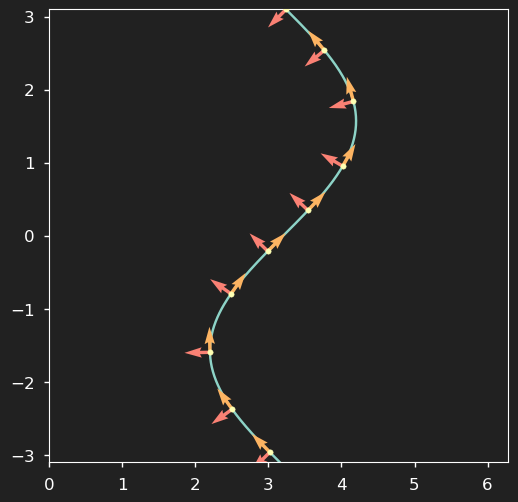

In [25]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(*ctr.T)
ax.scatter(*ctr_dat.T, s=15, c='C1', zorder=4)
ax.quiver(X, Y, XS, YS, color='C3')
ax.quiver(X, Y, XF, YF, color='C5', zorder=3)

ax.set_xlim([0, 2*np.pi])
ax.set_ylim([-3.1,3.1])
ax.set_aspect('equal')

plt.show()

## Sampling slow manifold

In [34]:
def plot_sman(data, sde, nreps, tspan, dt, c=None):
    ens0 = np.repeat(data, nreps, axis=0)
    nsteps = int(tspan[1]/dt)
    bursts = em.burst(sde, ens0, (0, nsteps), dt).reshape(len(data), nreps, 2)
    slow_means = np.nanmean(bursts, axis=1)
    plt.scatter(*slow_means.T, c=c, s=10)
    
    return slow_means

In [20]:
nreps = 5_000

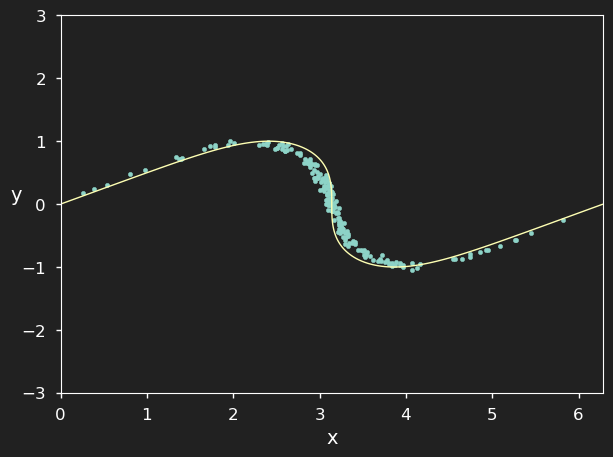

In [21]:
plot_sman(data[::20], sde, nreps, (0, 3*eps), dt/3)
plt.xlabel("x")
plt.ylabel("y", rotation=0)
plt.xlim([0,2*np.pi])
plt.ylim([-3,3])

mesh_size = 400
x = np.linspace(+0.0, 2*np.pi, mesh_size)
y = np.linspace(-3.0, 3.0, mesh_size)
X, Y = np.meshgrid(x, y)
S = np.sin(X - np.sin(Y)) - Y

plt.contour(X, Y, S, levels=[0], colors=cslow, linewidths=1)
# plt.plot(x, np.sin(x))
# plt.plot(x+np.sin(np.sin(x)), np.sin(x), '--', lw=1)

plt.show()

# Collapsing along the fibers

In [22]:
idx = 540
burst_size = 1_000
burst_dt = dt / 5
dpt = data[[idx]]
dpt.shape

(1, 2)

In [23]:
dpt_rep = np.repeat(dpt, burst_size, axis=0)
burst = em.burst(sde, dpt_rep, (0.0, 1), burst_dt)
burst.shape

(1000, 2)

In [24]:
burst_cov = np.cov(burst.T) / burst_dt
burst_avg = np.mean(burst, axis=0, keepdims=True)
burst_avg.shape

(1, 2)

In [25]:
e_vals, e_vecs = np.linalg.eigh(burst_cov)
e_vec1, e_vec2 = e_vecs.T
print(e_vec1, e_vec2)

[-0.87026918  0.49257645] [0.49257645 0.87026918]


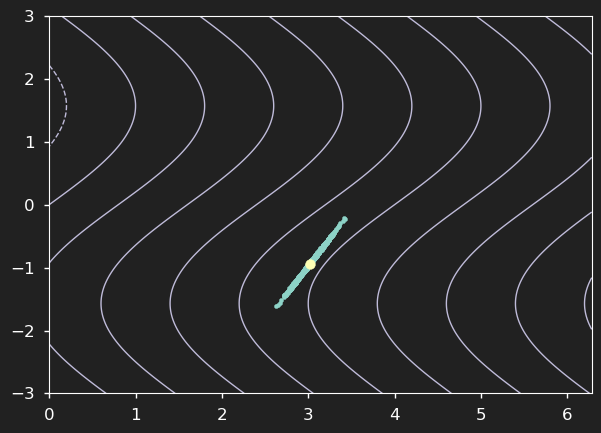

In [26]:
plt.scatter(*burst.T);
plt.scatter(*burst_avg.T, s=50);
# plt.quiver(*burst_avg.T, *e_vec1, color='C1');
# plt.quiver(*burst_avg.T, *e_vec2, color='C1');
plt.contour(X, Y, V, levels=10, colors=cfast, linewidths=1);

In [27]:
burst1 = burst_avg.T + np.dot(burst - burst_avg, e_vec1)*e_vecs.T[[0]].T
burst2 = burst_avg.T + np.dot(burst - burst_avg, e_vec2)*e_vecs.T[[1]].T

In [28]:
def proj(x, x0, v):
    return x + np.dot(x - x0, v) * v

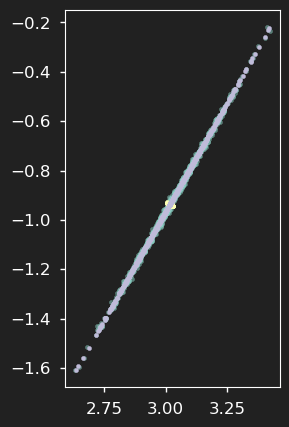

In [29]:
plt.scatter(*burst.T, alpha=0.5);
plt.scatter(*burst1);
plt.scatter(*burst2);
plt.gca().set_aspect('equal');

In [30]:
var1 = np.var(slow_map(burst1), axis=1)
var2 = np.var(slow_map(burst2), axis=1)

In [31]:
var1 / var2

array([0.04094723])

In [32]:
e_vals[0] / e_vals[1]

0.00035473044160188254

In [33]:
burst_avg = np.mean(burst, axis=0, keepdims=True)

In [34]:
from sklearn.decomposition import PCA

In [35]:
pca = PCA(n_components=2)

In [36]:
pca.fit(burst)

PCA(n_components=2)

In [37]:
print(pca.components_)

[[ 0.49257648  0.87026924]
 [-0.87026924  0.49257648]]


In [38]:
comp1, comp2 = pca.components_

In [39]:
saxis1 = (comp1+comp2) / np.linalg.norm(comp1+comp2)
saxis2 = (comp1-comp2) / np.linalg.norm(comp1-comp2)

In [40]:
saxis1 = saxis1[None,:]
saxis2 = saxis2[None,:]

In [41]:
print(pca.explained_variance_ratio_)

[9.996454e-01 3.546046e-04]


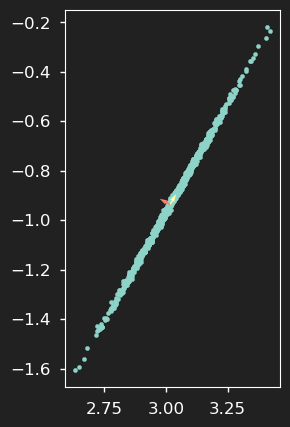

In [42]:
plt.scatter(*burst.T);
plt.quiver(*burst_avg.T, *comp1.T, color='C1');
plt.quiver(*burst_avg.T, *comp2.T, color='C3');
plt.gca().set_aspect('equal')

In [43]:
d1, d2 = pca.transform(burst).T

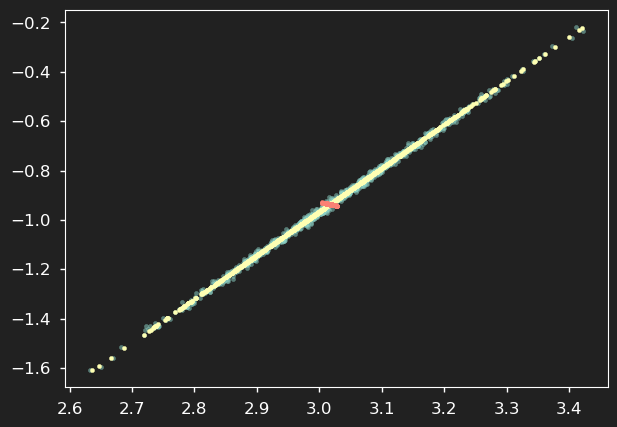

In [44]:
plt.scatter(*burst.T, alpha=.5)
plt.scatter( *(burst_avg.T + d1*comp1[:,None]), c='C1');
plt.scatter( *(burst_avg.T + d2*comp2[:,None]), c='C3');
# plt.scatter( *(burst_avg.T + d2*saxis2[:,None]), c='C3' );
# plt.gca().set_aspect('equal')

In [45]:
burst_size=10_000
var_ratios = []
svar_ratios = []
for dpt in data[::20]:
    dpt = dpt.reshape(1,2)
    dpt_rep = np.repeat(dpt, burst_size, axis=0)
    burst = em.burst(sde, dpt_rep, (0.0, 1), burst_dt)
    pca.fit(burst)
    comp1, comp2 = pca.components_
    d1, d2 = pca.transform(burst).T
    burst1 = burst_avg.T + d1*comp1[:,None]
    burst2 = burst_avg.T + d2*comp2[:,None]
    
    var1 = np.var(burst1, axis=1) / burst_dt
    var2 = np.var(burst2, axis=1) / burst_dt
    var_ratios.append(pca.explained_variance_ratio_)
#     var_ratios.append(var1 / var2)
    
    svar1 = np.squeeze(np.var(slow_map(burst1), axis=1))
    svar2 = np.squeeze(np.var(slow_map(burst2), axis=1))
    svart = svar1 + svar2
    svar_ratios.append([svar1 / svart, svar2 / svart])
    
var_ratios = np.array(var_ratios)
svar_ratios = np.array(svar_ratios)

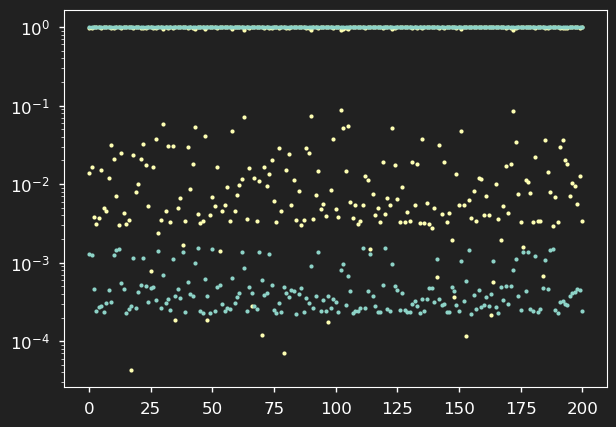

In [46]:
plt.plot(svar_ratios, 'o', c='C1');
plt.plot(var_ratios, 'o', c='C0');
plt.yscale('log')

## Relative variance in fibers images

In [47]:
burst_dt = dt / 20

In [48]:
fibs = em.solve(sde, data[::30], (0, 0.5*eps), burst_dt).p
fibs.shape

(134, 42, 2)

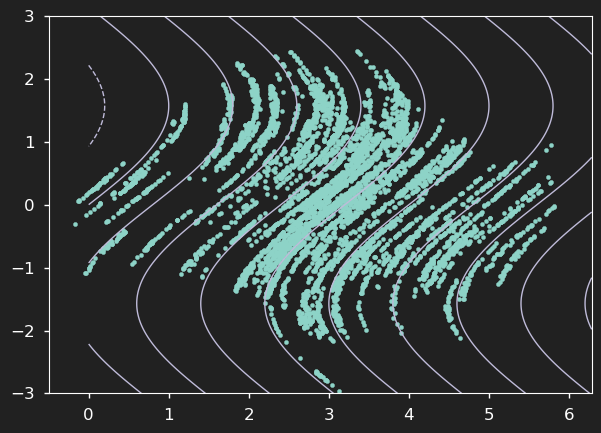

In [49]:
plt.scatter(*fibs.T)
plt.contour(X, Y, V, levels=10, colors=cfast, linewidths=1);

In [50]:
fibs_var = np.var(fibs,axis=1)
fibs_var.shape

(134, 2)

In [51]:
fibs_var[:5]

array([[0.1111563 , 0.18117282],
       [0.0048313 , 0.14778653],
       [0.05968977, 0.06436157],
       [0.01415428, 0.06043108],
       [0.06442583, 0.08539194]])

In [52]:
slow_map(fibs.T).T.shape

(134, 42, 1)

In [53]:
meanvar_sfibs = np.mean(np.var(slow_map(fibs.T).T, axis=1))
meanvar_sdata = np.mean(np.var(slow_map(data.T).T))

In [54]:
meanvar_sfibs / meanvar_sdata

0.00023571997877724072